## Import library

In [1]:
%run bert
%run utils.ipynb

import numpy as np
import pandas as pd
import sklearn as sk 
from sklearn.metrics import cohen_kappa_score,mean_absolute_error,mean_squared_error,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna

In [85]:
loader = DataLoader()
d = loader.GetData('L2Writing')
#d = loader.GetShuffled()
d.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [86]:
EmbeddingFetcher = GetBERTEmbeddings(d['full_text'],'model/deberta-base')
EmbeddingFetcher.inf(stop=1500,SeqLen = 512 )

tokenized


c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\deberta\modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\deberta\modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


0/1500, run:0
10/1500, run:0
20/1500, run:0
30/1500, run:0
40/1500, run:0
50/1500, run:0
60/1500, run:0
70/1500, run:0
80/1500, run:0
90/1500, run:0
100/1500, run:0
110/1500, run:0
120/1500, run:0
130/1500, run:0
140/1500, run:0
150/1500, run:0
160/1500, run:0
170/1500, run:0
180/1500, run:0
190/1500, run:0
200/1500, run:0
210/1500, run:0
220/1500, run:0
230/1500, run:0
240/1500, run:0
250/1500, run:0
260/1500, run:0
270/1500, run:0
280/1500, run:0
290/1500, run:0
300/1500, run:0
310/1500, run:0
320/1500, run:0
330/1500, run:0
340/1500, run:0
350/1500, run:0
360/1500, run:0
370/1500, run:0
380/1500, run:0
390/1500, run:0
400/1500, run:0
410/1500, run:0
420/1500, run:0
430/1500, run:0
440/1500, run:0
450/1500, run:0
460/1500, run:0
470/1500, run:0
480/1500, run:0
490/1500, run:0
500/1500, run:0
510/1500, run:0
520/1500, run:0
530/1500, run:0
540/1500, run:0
550/1500, run:0
560/1500, run:0
570/1500, run:0
580/1500, run:0
590/1500, run:0
600/1500, run:0
610/1500, run:0
620/1500, run:0
630

In [57]:
del EmbeddingFetcher.model
torch.cuda.empty_cache()

In [87]:
x = EmbeddingFetcher.GetEmbeddings('CLS')

In [89]:
x = [np.array(i).reshape(768) for i in x]
columns = ['cohesion', 'syntax', 'vocabulary','phraseology', 'grammar', 'conventions']
TrainX,TestX = x[:2800],x[2800:]

In [90]:
TrainY,TestY = [],[]
for i in columns:
    TrainY.append(d[i].iloc[:2800])
    TestY.append(d[i].iloc[2800:])

In [ ]:
def objective(trial):
    params = {"random_state":trial.suggest_categorical("random_state", [42]),           # categorical for concrete values
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),   # loguniform for continuos values
        "n_estimators": trial.suggest_int('n_estimators',50,2000),                 # int for discrete values. Interval between [100,2000]
        "max_depth" : trial.suggest_int("max_depth", 5, 15),
        "alpha" : trial.suggest_float('alpha',0.9,1),
        "tree_method": trial.suggest_categorical("tree_method", ['gpu_hist']), 
        "predictor": trial.suggest_categorical("predictor", ["gpu_predictor"])
    }
    error = []
    for i in range(6):
        model = xgb.XGBRegressor(**params)
        model.fit(TrainX,TrainY[i])
        PredY = model.predict(TestX)
        e = mean_squared_error(TestY[i],PredY,squared=False)
        error.append(e)
    mcrmse = sum(error)/6
    return mcrmse
study = optuna.create_study()
study.optimize(objective, n_trials=100) 

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history
plot_optimization_history(study)

In [9]:
def objective():
    params = {"random_state":42,          
        'learning_rate' : 0.05,   
        "n_estimators": 1000,                 
        "max_depth" : 8,
        "alpha" : 0.95,
        "tree_method": 'gpu_hist', 
        "predictor": "gpu_predictor"
    }
    error = []
    for i in range(6):
        model = xgb.XGBRegressor(**params)
        model.fit(TrainX,TrainY[i])
        PredY = model.predict(TestX)
        e = mean_squared_error(TestY[i],PredY,squared=False)
        error.append(e)
    mcrmse = sum(error)/6
    return mcrmse,error
objective()

(0.6326052962274167,
 [0.6416602899580893,
  0.6135895972640092,
  0.5586326844632896,
  0.6362760911765848,
  0.6990535555803693,
  0.6464195589221577])

In [104]:
TrainX,TestX = x[:2800],x[2800:3300]
TrainY,TestY = d['syntax'][:2800],d['syntax'][2800:3300]

In [105]:
model = xgb.XGBRegressor(base_score=0.05,learning_rate=0.05)
model.fit(TrainX,TrainY)

XGBRegressor(base_score=0.05, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [106]:
PredY = model.predict(TestX)

<AxesSubplot: xlabel='syntax'>

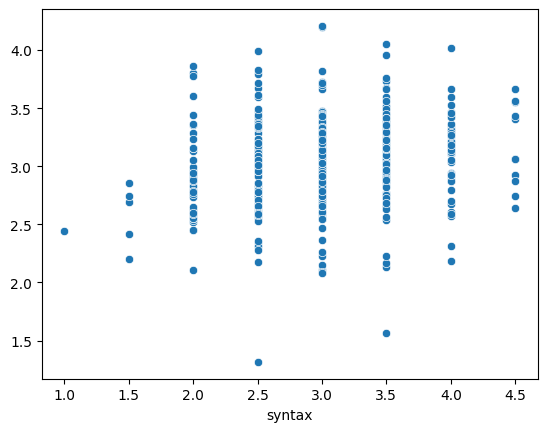

In [110]:
sns.scatterplot(x=TestY,y=PredY)

In [107]:
mean_squared_error(PredY,TestY,squared=False)

0.6402797500593467

In [65]:
mean_absolute_error(TestY,PredY,)

0.9237931060791016